In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv("/content/reply_classification_dataset.csv")

In [3]:
df.head()

,reply,label
0,Can we discuss pricing??,NEUTRAL
1,"Im excited to explore this further, plz send c...",POSITIVE
2,We not looking for new solutions.,negative
3,Could u clarify features included?,neutral
4,"lets,, schedule a meeting to dive deeper",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reply   2129 non-null   object
 1   label   2129 non-null   object
dtypes: object(2)
memory usage: 33.4+ KB


In [5]:
df['label'].unique()

array(['NEUTRAL', 'POSITIVE', 'negative', 'neutral', 'positive',
       'NEGATIVE', 'Positive', 'Neutral', 'Negative'], dtype=object)

In [6]:
def transform_label(text):

    positive_labels = ['POSITIVE', 'positive','Positive']
    negative_labels = ['negative', 'Negative', 'NEGATIVE']
    neutral_labels = ['neutral', 'Neutral', 'NEUTRAL']



    if text in positive_labels:
        return "positive"
    elif text in negative_labels:
        return "negative"
    elif text in neutral_labels:
        return "neutral"

In [7]:
for i, loc in df.iterrows():
    df.loc[i, 'label'] = transform_label(loc['label'])

In [8]:
df['label'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [9]:
df.isna().sum()

,0
reply,0
label,0


In [10]:
df['reply'][0]

'Can we discuss pricing??'

In [11]:
df['label'].value_counts()

,count
label,
positive,710
negative,710
neutral,709


In [12]:
df['label'].value_counts(normalize=True)

,proportion
label,
positive,0.33349
negative,0.33349
neutral,0.33302


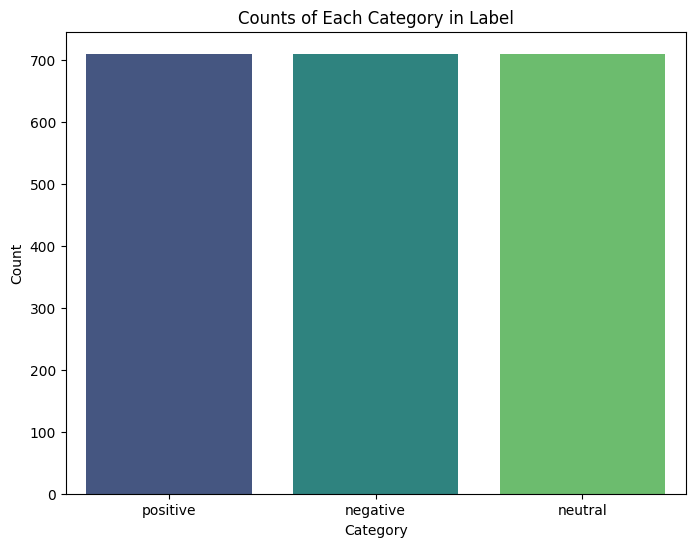

In [13]:
# Visualizing the counts of each category in label
label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis', legend=False)
plt.title('Counts of Each Category in Label')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [14]:
df['reply'].isna().sum()

np.int64(0)

In [15]:
df.isna().sum()

,0
reply,0
label,0


In [16]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize the text
    words = text.split()

    # Remove stop words and lemmatize
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the processed words back into a string
    return " ".join(processed_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [17]:
df["clean_text"] = df["reply"].apply(preprocess_text)

In [18]:
X = df['clean_text'].values
y = df['label'].values

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
X_train.shape

(1703,)

In [21]:
X_test.shape

(426,)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)

In [23]:
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, random_state=42)

In [25]:
clf.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [26]:
y_pred = clf.predict(X_test_transformed)

In [27]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9953051643192489


In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9953051643192489
F1 (macro): 0.9953615258572515

Classification Report:
               precision    recall  f1-score   support

    negative       0.99      0.99      0.99       150
     neutral       1.00      0.99      1.00       136
    positive       0.99      1.00      1.00       140

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



In [29]:
def predict_sentiment(text):

    preprocessed_text = preprocess_text(text)
    transformed_text = vectorizer.transform([preprocessed_text])
    sentiment = clf.predict(transformed_text)

    return sentiment[0]

In [30]:
print(df['reply'][0])

Can we discuss pricing??


In [31]:
print("Predicted Sentiment : ", predict_sentiment(df['reply'][0]))
print("Actual Sentiment : ", df['label'][0])

Predicted Sentiment :  neutral
Actual Sentiment :  neutral


In [32]:
print("Predicted Sentiment : ", predict_sentiment(df['reply'][20]))
print("Actual Sentiment : ", df['label'][20])

Predicted Sentiment :  negative
Actual Sentiment :  negative


In [34]:
import joblib

# Save
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(clf, "logreg_model.pkl")

# Load later
tfidf_loaded = joblib.load("tfidf_vectorizer.pkl")
clf_loaded = joblib.load("logreg_model.pkl")

# Example prediction
sample = ["Thanks for reaching out, I’m interested in a demo next week."]
sample_tfidf = tfidf_loaded.transform(sample)
print(clf_loaded.predict(sample_tfidf))


['positive']


In [35]:
import random

num = random.randint(0, len(df))

print("Reply : ", df['reply'][num])

print("Predicted Sentiment : ", predict_sentiment(df['reply'][num]))
print("Actual Sentiment : ", df['label'][num])

Reply :  No intrest right now
Predicted Sentiment :  negative
Actual Sentiment :  negative


In [36]:
data = pd.read_csv("/content/reply_classification_dataset.csv")

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reply   2129 non-null   object
 1   label   2129 non-null   object
dtypes: object(2)
memory usage: 33.4+ KB


In [38]:
data.label.unique()

array(['NEUTRAL', 'POSITIVE', 'negative', 'neutral', 'positive',
       'NEGATIVE', 'Positive', 'Neutral', 'Negative'], dtype=object)

In [39]:
def transform_label(text):

    positive_labels = ['POSITIVE', 'positive','Positive']
    negative_labels = ['negative', 'Negative', 'NEGATIVE']
    neutral_labels = ['neutral', 'Neutral', 'NEUTRAL']



    if text in positive_labels:
        return "positive"
    elif text in negative_labels:
        return "negative"
    elif text in neutral_labels:
        return "neutral"

In [40]:
for i, loc in data.iterrows():
    data.loc[i, 'label'] = transform_label(loc['label'])

In [41]:
data.label.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [42]:
data['reply'].value_counts()

,count
reply,
Not open to vendors,56
Were happy w/ setup,48
Not fit for strategy,46
No intrest in product,45
No need for this,45
...,...
"This could enhance workflow, discuss!",1
Doesnt align w/ needs,1
Lets schdule product overview,1


In [43]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize the text
    words = text.split()

    # Remove stop words and lemmatize
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the processed words back into a string
    return " ".join(processed_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [44]:
label_list = ["positive","neutral","negative"]
label2id = {l:i for i,l in enumerate(label_list)}

data["label_id"] = data["label"].map(label2id)

In [45]:
data["clean_text"] = data["reply"].apply(preprocess_text)

In [46]:
print("Before Cleaning and Processed text : ", data['reply'][0])
print("After Cleaning and Processed text : ", data['clean_text'][0])

Before Cleaning and Processed text :  Can we discuss pricing??
After Cleaning and Processed text :  discus pricing


In [47]:
print(data['label'][0], "->",data['label_id'][0])

neutral -> 1


In [48]:
data.drop(columns=['reply', 'label'], inplace=True)

In [49]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42
)

In [50]:
train_data.shape

(1703, 2)

In [51]:
test_data.shape

(426, 2)

In [52]:
train_data, val_data = train_test_split(
    train_data, test_size=0.125, random_state=42
)

In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

In [54]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [55]:
def preprocess(batch):
    return tokenizer(
        batch["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [56]:
train_ds = Dataset.from_pandas(
    train_data[["clean_text", "label_id"]].rename(columns={"label_id": "label"})
)
val_ds = Dataset.from_pandas(
    val_data[["clean_text", "label_id"]].rename(columns={"label_id": "label"})
)
test_ds = Dataset.from_pandas(
    test_data[["clean_text", "label_id"]].rename(columns={"label_id": "label"})
)

In [57]:
train_ds = train_ds.map(preprocess, batched=True)
val_ds = val_ds.map(preprocess, batched=True)
test_ds = test_ds.map(preprocess, batched=True)

Map:   0%|          | 0/1490 [00:00<?, ? examples/s]

Map:   0%|          | 0/213 [00:00<?, ? examples/s]

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

In [58]:
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [59]:
num_labels = len(data["label_id"].unique())

In [60]:
num_labels

3

In [61]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels = num_labels
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
# Training args
training_args = TrainingArguments(
    output_dir="./distilbert-svara",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none"
)

In [64]:
# Metrics
def compute_metrics(pred):

    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1_macro": f1}


In [65]:
# Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    compute_metrics = compute_metrics
)

In [66]:
# Train & Evaluate
trainer.train()
trainer.evaluate(eval_dataset = test_ds)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.086507,0.985915,0.986354
2,No log,0.035489,0.985915,0.986354
3,No log,0.030382,0.985915,0.986354


{'eval_loss': 0.09863431006669998,
 'eval_accuracy': 0.9812206572769953,
 'eval_f1_macro': 0.9813027544002288,
 'eval_runtime': 1.5689,
 'eval_samples_per_second': 271.522,
 'eval_steps_per_second': 34.418,
 'epoch': 3.0}

In [68]:
# Save tokenizer
tokenizer.save_pretrained("./distilbert-svara-best")

# Save model
trainer.save_model("./distilbert-svara-best")

In [69]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("./distilbert-svara-best")
model = AutoModelForSequenceClassification.from_pretrained("./distilbert-svara-best")

# Example usage
inputs = tokenizer("Can we schedule a demo next week?", return_tensors="pt")
outputs = model(**inputs)
pred = outputs.logits.argmax(dim=1).item()
print("Predicted label_id:", pred)


Predicted label_id: 0


In [70]:
label2id = {"positive": 0, "neutral": 1, "nagative": 2}
id2label = {v: k for k, v in label2id.items()}

In [72]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained("./distilbert-svara-best")
model = AutoModelForSequenceClassification.from_pretrained(
    "./distilbert-svara-best",
    id2label=id2label,     # attaches human-readable labels
    label2id=label2id
)

# Run inference
inputs = tokenizer("Can we schedule a demo next week?", return_tensors="pt")
outputs = model(**inputs)
pred_id = outputs.logits.argmax(dim=1).item()
pred_label = model.config.id2label[pred_id]

print("Prediction:", pred_label)

Prediction: positive


In [73]:
!pip freeze > requirements.txt

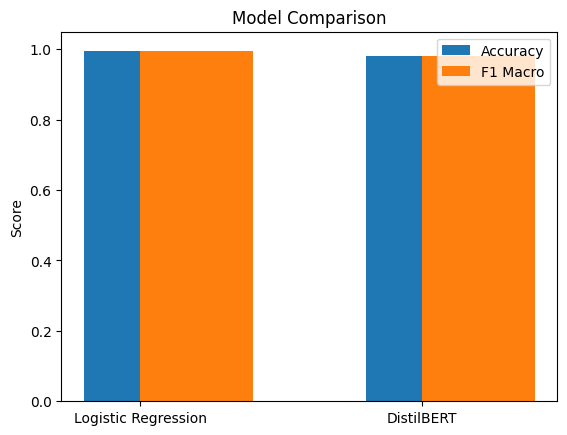

In [74]:
import matplotlib.pyplot as plt

models = ["Logistic Regression", "DistilBERT"]
accuracy = [0.9953, 0.9812]
f1_macro = [0.9954, 0.9813]

x = range(len(models))
plt.bar(x, accuracy, width=0.4, label="Accuracy", align="center")
plt.bar(x, f1_macro, width=0.4, label="F1 Macro", align="edge")
plt.xticks(x, models)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison")
plt.legend()
plt.show()

For this dataset of short email replies, Logistic Regression with TF-IDF achieves higher accuracy and macro F1 than a fine-tuned DistilBERT. Given its simplicity, speed, and low memory footprint, Logistic Regression is the preferred choice for production.

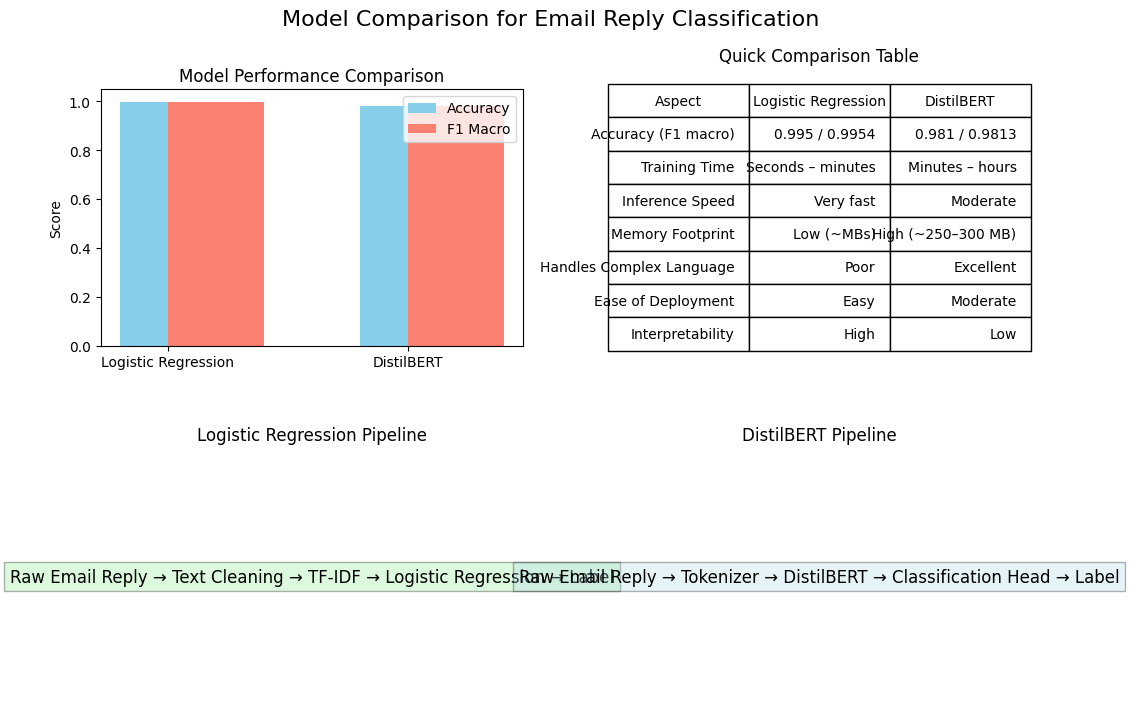

In [75]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# -----------------------
# Model metrics
models = ["Logistic Regression", "DistilBERT"]
accuracy = [0.9953, 0.9812]
f1_macro = [0.9954, 0.9813]

# -----------------------
# Figure layout
plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], hspace=0.4)

# Bar chart
ax0 = plt.subplot(gs[0, 0])
x = range(len(models))
ax0.bar(x, accuracy, width=0.4, label="Accuracy", align="center", color='skyblue')
ax0.bar(x, f1_macro, width=0.4, label="F1 Macro", align="edge", color='salmon')
ax0.set_xticks(x)
ax0.set_xticklabels(models)
ax0.set_ylim(0, 1.05)
ax0.set_ylabel("Score")
ax0.set_title("Model Performance Comparison")
ax0.legend()

# Logistic Regression pipeline diagram
ax1 = plt.subplot(gs[1, 0])
ax1.axis('off')
pipeline_logreg = "Raw Email Reply → Text Cleaning → TF-IDF → Logistic Regression → Label"
ax1.text(0.5, 0.5, pipeline_logreg, ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgreen', alpha=0.3))
ax1.set_title("Logistic Regression Pipeline")

# DistilBERT pipeline diagram
ax2 = plt.subplot(gs[1, 1])
ax2.axis('off')
pipeline_bert = "Raw Email Reply → Tokenizer → DistilBERT → Classification Head → Label"
ax2.text(0.5, 0.5, pipeline_bert, ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.3))
ax2.set_title("DistilBERT Pipeline")

# Table with quick comparison
ax3 = plt.subplot(gs[0, 1])
ax3.axis('off')
table_data = [
    ["Accuracy (F1 macro)", "0.995 / 0.9954", "0.981 / 0.9813"],
    ["Training Time", "Seconds – minutes", "Minutes – hours"],
    ["Inference Speed", "Very fast", "Moderate"],
    ["Memory Footprint", "Low (~MBs)", "High (~250–300 MB)"],
    ["Handles Complex Language", "Poor", "Excellent"],
    ["Ease of Deployment", "Easy", "Moderate"],
    ["Interpretability", "High", "Low"]
]
columns = ["Aspect", "Logistic Regression", "DistilBERT"]
table = ax3.table(cellText=table_data, colLabels=columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax3.set_title("Quick Comparison Table", pad=20)

plt.suptitle("Model Comparison for Email Reply Classification", fontsize=16)
plt.show()
